**Author**: Petru Potrimba <br>
**Matriculation**:  928850

# Visual Inspection of Motorcycle Connecting Rods

### Utility function

In [316]:
def defect_convexity_algorithm(imgf):
    
    img, contours, hierarchy = cv.findContours(imgf.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    sepc = -1
    for i in range(len(contours)):
        if(len(contours[i])) >= 326: # there are touching elements
            sepc = i
            break
    
    cnt = contours[sepc]
    hull = cv.convexHull(cnt, returnPoints = False)
    defects = cv.convexityDefects(cnt, hull)

    collision_points = []
    
    if sepc != -1: # if there are touching rods, add them
         for i in range(defects.shape[0]):
            s,e,f,d = defects[i,0]
            far = tuple(cnt[f][0])
            if (far[0] - 1 >= 0) and (far[1] - 1 >= 0) and (far[0] + 1 <= 255) and (far[1] + 1 <= 255) and (far[0] - 2 >= 0) and (far[1] - 2 >= 0) and (far[0] + 2 <= 255) and (far[1] + 2 <= 255):
                octet_sum = int(img[far[1] - 1, far[0]]) + int(img[far[1] - 1, far[0] - 1]) + int(img[far[1], far[0] - 1]) + int(img[far[1] + 1, far[0] - 1]) + int(img[far[1] + 1, far[0]]) + int(img[far[1] + 1, far[0] + 1]) + int(img[far[1], far[0] + 1]) + int(img[far[1] - 1, far[0] + 1]) + int(img[far[1] - 2, far[0]]) + int(img[far[1] - 2, far[0] - 1]) + int(img[far[1] - 2, far[0] - 2]) + int(img[far[1] -1, far[0] - 2]) + int(img[far[1], far[0] - 2]) + int(img[far[1] + 1, far[0] - 2]) + int(img[far[1] + 2,far[0] - 2]) + int(img[far[1] + 2, far[0] - 1]) + int(img[far[1] + 2, far[0]]) + int(img[far[1] + 2, far[0] + 1]) + int(img[far[1] + 2, far[0] + 2]) + int(img[far[1] + 1, far[0] + 2]) + int(img[far[1], far[0] + 2]) + int(img[far[1] - 1, far[0] + 2]) + int(img[far[1] - 2, far[0] + 2]) + int(img[far[1] - 2, far[0] + 1])
                collision_points.append([far, octet_sum, False])
            
    if len(collision_points) > 0:
        # calculate threshold            
        white_pixel_value_sum = []
        for i in range(len(collision_points)):
            white_pixel_value_sum.append(collision_points[i][1])
        remove_duplicate_list = np.sort(list(set(white_pixel_value_sum)))

        changes_between_values = []
        for i in range(len(remove_duplicate_list) - 1):
            changes_between_values.append(remove_duplicate_list[i + 1] - remove_duplicate_list[i])
        max_change = np.argmax(changes_between_values)
        threshold = int(round((remove_duplicate_list[max_change + 1] + remove_duplicate_list[max_change]) / 2))
    

        # calculate euclidean distance
        for i in range(len(collision_points) - 1):
            distance_from_i_to_j = math.inf
            index_of_j = -1
            if collision_points[i][1] <= threshold and collision_points[i][2] == False: # means that still need to find its miniumum distance point
                for j in range(i + 1, len(collision_points)):
                    dst = distance.euclidean([collision_points[i][0][0], collision_points[i][0][1]], [collision_points[j][0][0], collision_points[j][0][1]])
                    if dst < distance_from_i_to_j and collision_points[j][2] == False:
                        distance_from_i_to_j = dst
                        index_of_j = j
                # draw line
                cv.line(img,(collision_points[i][0][0],collision_points[i][0][1]),(collision_points[index_of_j][0][0],collision_points[index_of_j][0][1]),(255,0, 0),1)
                collision_points[i][2] = True
                collision_points[index_of_j][2] = True
                
    return img

def compute_width_at_barycenter(barX, barY, contours):
    max_distance_from_bar = - math.inf
    index_of_j = -1
    for j in range(len(contours[i])):
        dst = distance.euclidean([barX, barY], [contours[j][0][0], contours[j][0][1]])
        if dst > max_distance_from_bar:
            max_distance_from_bar = dst
            index_of_j = j

    x1 = contours[index_of_j][0][0]
    x2 = round(barX)
    y1 = contours[index_of_j][0][1]
    y2 = round(barY)
    xdif = x2 - x1
    ydif = y2 - y1

    line_len_at_barycenter = 3

    a1 = int(round(x2 - ydif / line_len_at_barycenter))
    b1 = int(round(y2 + xdif / line_len_at_barycenter))

    a2 = int(round(x2 + ydif / line_len_at_barycenter))
    b2 = int(round(y2 - xdif / line_len_at_barycenter))

    distance_from_i_to_j = math.inf
    index_of_j = -1
    for j in range(len(contours)):
        dst = distance.euclidean([a1, b1], [contours[j][0][0], contours[j][0][1]])
        if dst < distance_from_i_to_j:
            distance_from_i_to_j = dst
            index_of_j = j

    distance_from_i_to_k = math.inf
    index_of_k = -1

    for k in range(len(contours)):
        dst = distance.euclidean([a2, b2], [contours[k][0][0], contours[k][0][1]])
        if dst <= distance_from_i_to_k:
            distance_from_i_to_k = dst
            index_of_k = k
    return distance.euclidean([contours[index_of_j][0][0], contours[index_of_j][0][1]], [contours[index_of_k][0][0], contours[index_of_k][0][1]])

### Original mage

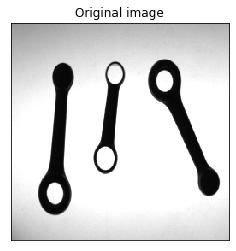

In [317]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import distance
import math

plt.figure(figsize=(4,4))

original_img = cv.imread('testImages/TESI00.BMP', 0)
img = original_img.copy()
plt.imshow(img, cmap='gray',vmin=0,vmax=255)
plt.title('Original image'), plt.xticks([]), plt.yticks([])
plt.show()

### Apply Otsu's tresholding

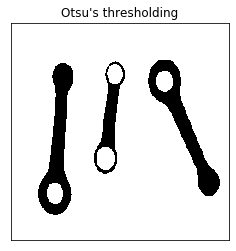

In [318]:
ret, otsu_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
plt.imshow(otsu_img,cmap = 'gray')
plt.title('Otsu\'s thresholding'), plt.xticks([]), plt.yticks([])
plt.show()

### Handling touching rods

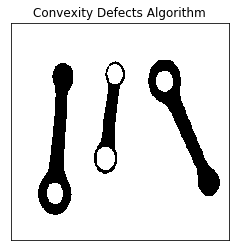

In [319]:
separate_rods_img = defect_convexity_algorithm(otsu_img)
plt.imshow(separate_rods_img,cmap = 'gray')
plt.title('Convexity Defects Algorithm'), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(len(separate_rods_img)), li, linewidth=1, c='r')
plt.ylabel('Cost Value')
plt.xlabel('Iteration of Gradient Descent')
plt.show()

### Labeling rods type

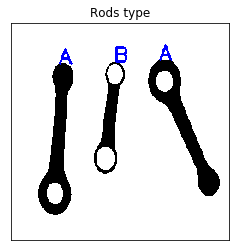

In [320]:
img, contours, hierarchy = cv.findContours(separate_rods_img.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
for i in range(hierarchy.shape[1]):
    if hierarchy[0, i][3] == 0 and hierarchy[0, i][2] != -1 and len(contours[i]) >= 72:
        if len(hierarchy[:, np.where(hierarchy[0][:, 3] == i)][0][0]) == 1:
            img = cv.putText(img, 'A', (contours[i][0][0][0], contours[i][0][0][1]), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2, cv.LINE_4)
            plt.imshow(img,cmap = 'gray')
            plt.title('Rods type'), plt.xticks([]), plt.yticks([])
        elif len(hierarchy[:, np.where(hierarchy[0][:, 3] == i)][0][0]) > 1:
            img = cv.putText(img, 'B', (contours[i][0][0][0], contours[i][0][0][1]), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2, cv.LINE_4)
            plt.imshow(img,cmap = 'gray')
            plt.title('Rods type'), plt.xticks([]), plt.yticks([])
            
plt.show()

### Position, orientation, length, width and width at the barycenter Wb 

Position:  (51.93987274169922, 136.43801879882812) , Orientation:  -89.12532043457031
Length:  179.19285583496094 , Width:  40.0869255065918 , Width at the barycenter(Wb):  18.027756377319946
------------------------------------------------------------------------------------------------
Position:  (114.32376861572266, 111.43852996826172) , Orientation:  -84.80557250976562
Length:  133.72129821777344 , Width:  28.971439361572266 , Width at the barycenter(Wb):  16.1245154965971
------------------------------------------------------------------------------------------------
Position:  (200.18011474609375, 124.6065673828125) , Orientation:  -20.400209426879883
Length:  171.22802734375 , Width:  41.65089416503906 , Width at the barycenter(Wb):  18.110770276274835
------------------------------------------------------------------------------------------------


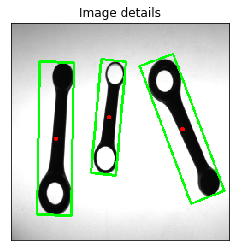

In [321]:
img = original_img.copy()
img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
for i in range(hierarchy.shape[1]):
    if hierarchy[0, i][3] == 0 and hierarchy[0, i][2] != -1 and len(contours[i]) >= 72:
        rect = cv.minAreaRect(contours[i])
        box = cv.boxPoints(rect)
        box = np.int0(box)
        img = cv.drawContours(img,[box],0,(0, 255, 0), 2)
        width_at_barycenter = compute_width_at_barycenter(rect[0][0], rect[0][1], contours[i])
        print("Position: ", rect[0], ", Orientation: ", rect[2])
        print("Length: ", rect[1][0] if rect[1][0] > rect[1][1] else rect[1][1], ", Width: ", 
              rect[1][1] if rect[1][1] < rect[1][0] else rect[1][0], ", Width at the barycenter(Wb): ", width_at_barycenter)
        print("------------------------------------------------------------------------------------------------")
        
        # draw barycenter
        img = cv.circle(img, center=(round(rect[0][0]), round(rect[0][1])), radius=1, color=(255, 0, 0) , thickness=2) 
        plt.imshow(img, cmap = 'gray')
        plt.title('Image details'), plt.xticks([]), plt.yticks([])
plt.show()

### For each hole, position of the centre and diameter size

Centre position:  (61.193511962890625, 93.17202758789062)
Diameter:  23.611258506774902
------------------------------------------------------------------------------------------------
Centre position:  (61.193511962890625, 93.17202758789062)
Diameter:  22.218055725097656
------------------------------------------------------------------------------------------------
Centre position:  (61.193511962890625, 93.17202758789062)
Diameter:  24.759586334228516
------------------------------------------------------------------------------------------------
Centre position:  (61.193511962890625, 93.17202758789062)
Diameter:  23.544066429138184
------------------------------------------------------------------------------------------------


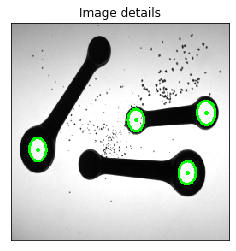

In [279]:
img = original_img.copy()
img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
for i in range(hierarchy.shape[1]):
    if hierarchy[0, i][3] > 0 and len(contours[i]) > 24 and len(contours[hierarchy[0, i][3]]) >= 72: # if the parent of the hole has a perimeter greater than 72 (basically here I am verifying whether the hole's parent is a rod)
        (x, y), (MA, ma), angle = cv.fitEllipse(contours[i])
        ellipse = cv.fitEllipse(contours[i])
        img = cv.ellipse(img ,ellipse,(0,255,0),2)
        print("Centre position: ", (x, y))
        print("Diameter: ", (MA + ma) / 2)
        print("------------------------------------------------------------------------------------------------")
        # draw barycenter
        img = cv.circle(img, center=(round(x), round(y)), radius=1, color=(0, 255, 0) , thickness=2) 
        plt.imshow(img, cmap = 'gray')
        plt.title('Image details'), plt.xticks([]), plt.yticks([])
plt.show()

# Project report

## First Task

### Type of rod (A or B)

In order to understand whether a rod has one hole (type A) or two holes (type B), the idea is to use the OpenCV function `findContours` which returns a hierarchical matrix that specifies, for each blob contour, the information regarding which is the **next** contour at its same level, the **previous** contour at its same level, who is its **first child** and who is its **parent**.

Using these information it will be easy to classify whether a rod is of type A or B.

But, in order to apply that function, we need to segment the blobs, so the first thing to do is a **segmentation**. <br>
The segmentation algorithm I decided to use is the **Otsu's segmentation** since it effectively calculate an automatic threshold even though the images have been taken by a different lighting power.

### Position and orientation (modulo $\pi$)

The position and orientation of the blobs have been calculated using the OpenCV function `minAreaRect` which returns a Box2D structure which contains following details: $$ rect = [center (x,y), \space(width, height), \space angle \space of \space rotation]$$

where *center(x, y)* represents the coordinates of the blob barycenter, *width* and *height* are the size of the MER and *angle of rotation* is the orientation of the blob. <br>

The **position** of the objects has been underlined drawing the MER of each blob. To draw the MER I needed to calculate first its 4 corners using the function `boxPoints(rect)` passing as argument the output returned by *minAreaRect*.


The **orientation** is the *angle of rotation* given by the *minAreaRect* function.

### Length (L), Width (W), Width at the barycenter ($W_B$)

The **length** coincide with the *height* whereas the **width** coincide with the *width* (both returned by *minAreaRect* function.

The width at the barycenter **$W_b$** is computed by the function I implemented `compute_width_at_barycenter`. <br>
The function performs the following steps:
     - for each rod:
        - calculate the line perpendicular at major axis and give it a generic length.
        - take the extrema coordinates of this line and compute the minimum Euclidean distance between these
          extrema coordinates and the contour points of the rod.
        - then, the width at the barycenter is given by the Euclidean distance between the two points found.

Belowe is shown an example of the points that my algorithm finds:

<img src="img_project/width_at_barycenter.png">

### For each hole, position of the centre and diameter size

To accomplish this task I used the function `fitEllipse` that fits an ellipse around a set of 2D points. <br>
This function returns the following details: 
$$ ellipse = [center (x,y), \space(Major \space axis, Minor \space axis), \space angle \space of \space rotation]$$

where *center(x, y)* represents the coordinates of the circle barycenter, *Major axis* and *Minor axis* are the lefnth of the Major and Minor axes of the circle and *angle of rotation* is the orientation of the circle.

The **hole position** coincide witht the *center(x, y)*, while the **hole diameter size** has been calculated as follows: 

$$\frac{Major \space axis + Minor \space axis}{2}$$

I decided to calculate the hole diameter size in that way because the holes are distorted. So in order to get a better approximation, I decided to take the mean between the Major and Minor axes.

## Second Task

max noise contour == 12

min non noise contour == 35

threshold = (12 + 35) / 2 -> 24

-------

hierarchy[0, i][3] == 0 : if my parent is zero, it means that I'am a rod. <br>
hierarchy[0, i][2] != -1 : if a rod has a first child, it means it is a rod and not a bolt, so it will be analyzed. <br>
len(contours[i]) >= 72 : of the perimeter of the blob took into account is greater than the empirical value 72, it means that it is a rod an not a washers, so it will be analyzed.

------

max area rondella == 64

min area biella == 80

threshold = (64 + 80) / 2 -> 72

------

max area biella == 256

min area touching bielle == 397

threshold for touching elements: (256 + 397) / 2 -> 326